In [4]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [5]:
df = pd.read_csv('Stocks\GOOG.csv')

## Quick look at data

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


In [7]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close', 'Volume']]

In [8]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1183 non-null   object 
 1   Close   1183 non-null   float64
 2   Volume  1183 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 27.9+ KB


**Data Time Period**

In [9]:
df['Date'].min(), df['Date'].max()

('2019-04-22', '2023-12-29')

## Visualize the data

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], name='Volume'))
fig2.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig2.show()

## Data Preprocessing

In [11]:
df[['Close','Volume']].head()

,Close,Volume
0,62.442001,16146000
1,63.227501,26398000
2,62.799999,20376000
3,63.172501,22146000
4,63.609001,24828000


In [12]:
scaler = StandardScaler()
scaler = scaler.fit(df[['Close','Volume']])
scaled_train = scaler.transform(df[['Close','Volume']])
#train_df = pd.DataFrame(scaled_train,columns = ['Close','Volume'])

In [13]:
scaled_train[0:5]

array([[-1.3374812 , -1.00458351],
       [-1.31047676, -0.21576535],
       [-1.32517371, -0.67911523],
       [-1.31236759, -0.54292638],
       [-1.2973613 , -0.33656564]])

In [14]:
def generate_sequences(data, window_size):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    Xs.append(data[i:i+window_size,:])
    #Ys.append(data[i+window_size,:]) # For multi target variables
    Ys.append(data[i+window_size,:][0]) # For single target variable
  return np.array(Xs), np.array(Ys)

In [15]:
TIME_STEPS = 5
X_train, Y_train= generate_sequences(scaled_train, TIME_STEPS)
print("Training input shape: ", X_train.shape)
print("Training input shape: ", Y_train.shape)

Training input shape:  (1178, 5, 2)
Training input shape:  (1178,)


In [16]:
X_train[0]

array([[-1.3374812 , -1.00458351],
       [-1.31047676, -0.21576535],
       [-1.32517371, -0.67911523],
       [-1.31236759, -0.54292638],
       [-1.2973613 , -0.33656564]])

In [17]:
Y_train.shape

(1178,)

In [18]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

In [19]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(rate=0.1))
#model.add(Dense(X_train.shape[2])) # For multi target variables
model.add(Dense(1))  # For single target variable
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,545
Trainable params: 116,545
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [20]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                    shuffle=False)

Epoch 1/100
30/30 [==============================] - 10s 67ms/step - loss: 0.9915 - val_loss: 0.4814
Epoch 2/100
30/30 [==============================] - 1s 20ms/step - loss: 0.4356 - val_loss: 0.3388
Epoch 3/100
30/30 [==============================] - 1s 21ms/step - loss: 0.4823 - val_loss: 0.2760
Epoch 4/100
30/30 [==============================] - 1s 18ms/step - loss: 0.3556 - val_loss: 0.3916
Epoch 5/100
30/30 [==============================] - 1s 21ms/step - loss: 0.1942 - val_loss: 0.1757
Epoch 6/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0660 - val_loss: 0.0222
Epoch 7/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0479 - val_loss: 0.0496
Epoch 8/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0579 - val_loss: 0.0243
Epoch 9/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0302 - val_loss: 0.0262
Epoch 10/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0320 - val_loss: 0.020

#### Plot Training - Validation loss

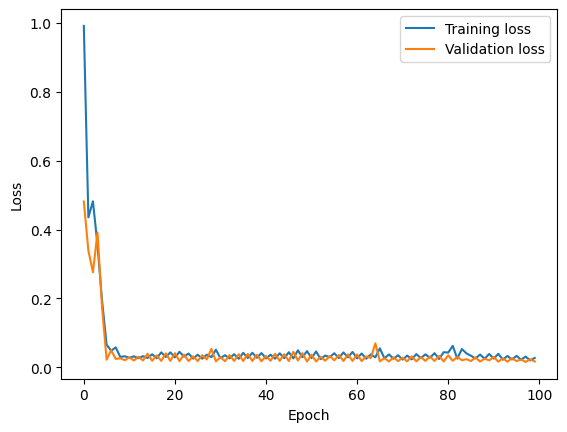

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [22]:
model.save('saved_models/lstm.h5')

In [23]:
new_df = pd.read_csv('Stocks\Test.csv')
new_df = new_df[['Date','Close','Volume']]
scaled_new_test = scaler.transform(new_df[['Close','Volume']])
X_new, Y_new = generate_sequences(scaled_new_test, TIME_STEPS)
new_test_pred = model.predict(X_new, verbose=1)


3/3 [==============================] - 1s 7ms/step


In [24]:
import shap
import tensorflow as tf
user_model = tf.keras.models.load_model('saved_models\lstm.h5')

c:\Users\ragam\.conda\envs\aioenv\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\ragam\.conda\envs\aioenv\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\ragam\.conda\envs\aioenv\lib\site-packages\shap\utils\_clustering.py:63: NumbaDeprecationWarning:



In [25]:
explainer = shap.GradientExplainer(user_model, X_new)
shap_values = explainer.shap_values(X_new)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [39]:
for val in shap_values:
    print(type(val))
    print('----------')

<class 'numpy.ndarray'>
----------


In [31]:
print(shap_values[0].shape) # Close Price
print(shap_values[1].shape) # Volume
print(len(shap_values))
print(X_new.shape)

(71, 5, 2)


IndexError: list index out of range

In [28]:
last_idx_arr = []
for item in shap_values[0]:
    #print(item[-1])
    last_idx_arr.append(item[-1])
last_idx_arr = np.array(last_idx_arr)
print(last_idx_arr.shape)

(71, 2)


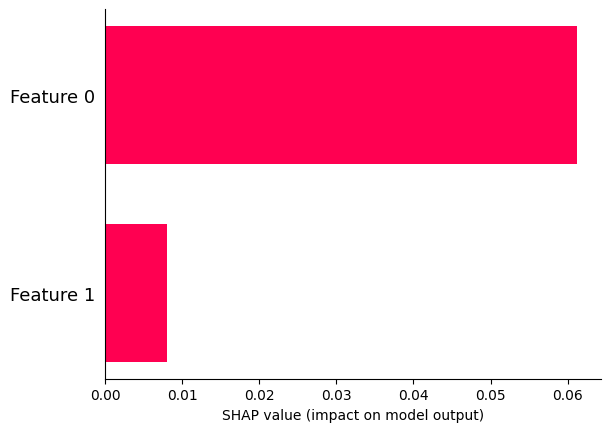

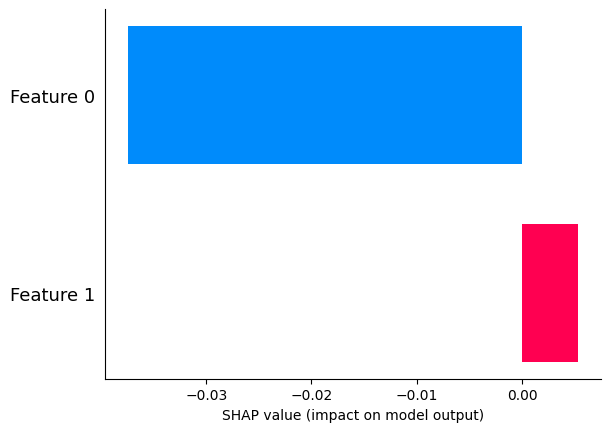

In [29]:
shap.bar_plot(last_idx_arr[70])
shap.bar_plot(last_idx_arr[0])

In [30]:
last_idx_arr2 = []
for item in shap_values[1]:
    #print(item[-1])
    last_idx_arr2.append(item[-1])
last_idx_arr2 = np.array(last_idx_arr2)
print(last_idx_arr2.shape)

IndexError: list index out of range

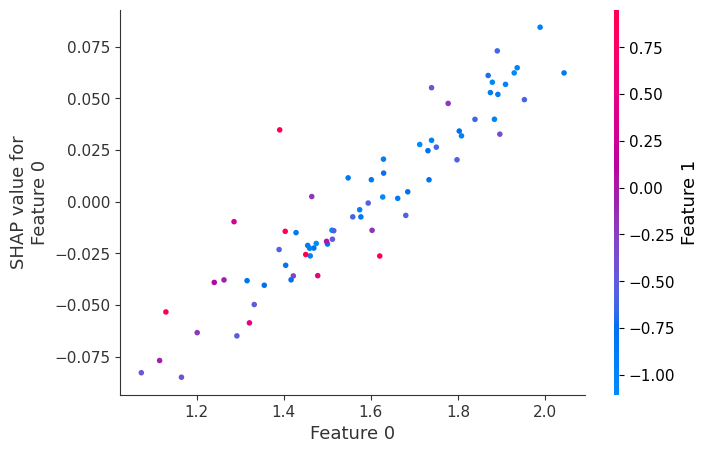

In [ ]:
shap.dependence_plot(0, last_idx_arr, scaled_new_test[TIME_STEPS:]) 
#shap.dependence_plot(1, last_idx_arr2, scaled_new_test[TIME_STEPS:]) 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


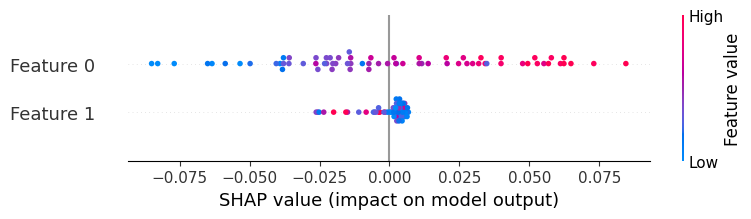

In [ ]:
shap.summary_plot(last_idx_arr, scaled_new_test[TIME_STEPS:]) #Close Price
#shap.summary_plot(last_idx_arr2, scaled_new_test[TIME_STEPS:]) #Volume

## Test graphs using only anomalies

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


(71, 2)
(71, 2)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


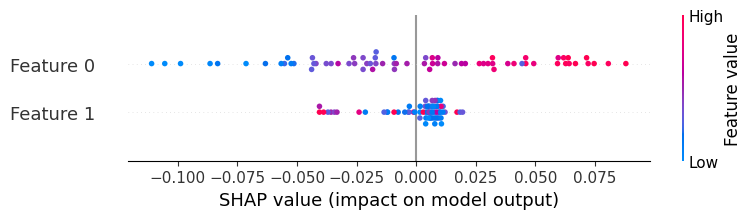

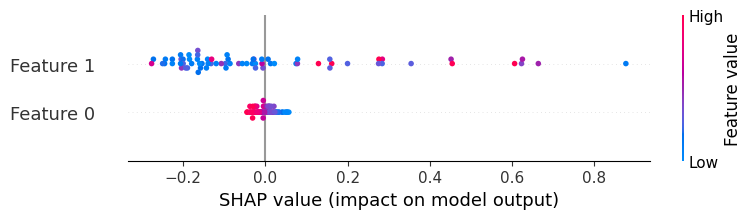

In [ ]:
a_df = pd.read_csv('Stocks\Anomaly.csv')
a_df = new_df[['Date','Close','Volume']]
scaled_a_test = scaler.transform(a_df[['Close','Volume']])
X_a, Y_a = generate_sequences(scaled_a_test, TIME_STEPS)

explainer2 = shap.GradientExplainer(user_model, X_a)
shap_values2 = explainer2.shap_values(X_a)


last_idx_arr_a= []
for item in shap_values2[0]:
    #print(item[-1])
    last_idx_arr_a.append(item[-1])
last_idx_arr_a = np.array(last_idx_arr_a)
print(last_idx_arr_a.shape)

last_idx_arr_a2 = []
for item in shap_values2[1]:
    #print(item[-1])
    last_idx_arr_a2.append(item[-1])
last_idx_arr_a2 = np.array(last_idx_arr_a2)
print(last_idx_arr_a2.shape)

shap.summary_plot(last_idx_arr_a, scaled_a_test[TIME_STEPS:]) #Close Price
shap.summary_plot(last_idx_arr_a2, scaled_a_test[TIME_STEPS:]) #Volume

## Evaluate Results

In [ ]:
pred_dict = {
    'Predicted_Close': new_test_pred[:, 0],
    'Predicted_Volume': new_test_pred[:, 1],
    'Actual_Close': Y_new[:, 0],
    'Actual_Volume': Y_new[:, 1],
}

In [ ]:
pred_df = pd.DataFrame(pred_dict)
pred_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
#  highlight the  forecast
highlight_start = int(len(pred_df) * 0.9)  
highlight_end = len(pred_df) - 1  # Adjusted to stay within bounds
# Plot the actual values
plt.plot(pred_df[['Actual_Close', 'Actual_Volume']][:highlight_start], label=['Actual_Close', 'Actual_Volume'])
 
# Plot predicted values with a dashed line
plt.plot(pred_df[['Predicted_Close', 'Predicted_Volume']], label=['Predicted_Close', 'Predicted_Volume'], linestyle='--')
 
# Highlight the forecasted portion with a different color
plt.axvspan(pred_df.index[highlight_start], pred_df.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')
 
plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()